# Bluetooth RSSI - Model evaluation

## Python imports

In [9]:
import numpy as np
import os.path
import matplotlib.pyplot as pyplt
import matplotlib.ticker
import pandas as pd
import pickle

## Read test datasets (base test split + Pixel & Xiaomi walks)

In [10]:
DATASET_IDS = ['TS', 'PW', 'RW' ]
#DATASET_IDS = ['TS',  'PTS', 'RTS', 'PW',  'RW']
MODELS = [ 'AdaBoost', 'DecisionTree', 'GradientBoost', 'KNN', 'LinearSVM', 'MLP', 'RandomForest', 'RBFSVM']
#MODELS = [ 'RandomForest', 'RandomForest_Pixel', 'RandomForest_Redmi']
DATASETS = { id: pd.read_csv('datasets/brssi/' + id + '.tsv', sep='\t') for id in DATASET_IDS }

## Evaluate accuracy for all model-test set combinations

In [11]:
results = []
for m in MODELS:
    with open(os.path.join('models/brssi/', m + '.pkl'), 'rb') as f:
        classifier = pickle.load(f)
        r = [m]
        for d,df in DATASETS.items():
            y = df['label']
            X = df.drop(columns=['source','time','label'])
            y_pred = classifier.predict_proba(X)
            results_df = pd.DataFrame()
            results_df['label'] = df['label']
            results_df['time'] = df['time']
            results_df['source'] = df['source']
            for idx,cat in enumerate(classifier.classes_):
                results_df[cat] = [ y[idx] for y in y_pred]
            results_df['prediction'] = results_df[classifier.classes_].idxmax(axis='columns')
            #print(type(classifier.classes_))
            results_df = results_df.loc[:, ['label','time','source','prediction'] + list(classifier.classes_)]
            results_df.sort_values(by=['label','source','time'], inplace=True)
            results_df.to_csv('results/brssi/'+ m + '_' + d + '.tsv', header=True, index=False, sep='\t')
            r.append(classifier.score(X,y))
        results.append(r)
plot_data = pd.DataFrame(results, columns=['Model'] + DATASET_IDS)
plot_data

,Model,TS,PW,RW
0,AdaBoost,0.682622,0.719251,0.527115
1,DecisionTree,0.744017,0.649733,0.535792
2,GradientBoost,0.904266,0.794118,0.763557
3,KNN,0.593132,0.550802,0.409978
4,LinearSVM,0.800208,0.743316,0.626898
5,MLP,0.687825,0.649733,0.494577
6,RandomForest,0.920916,0.850267,0.822126
7,RBFSVM,0.780437,0.687166,0.603037


## Derive plot

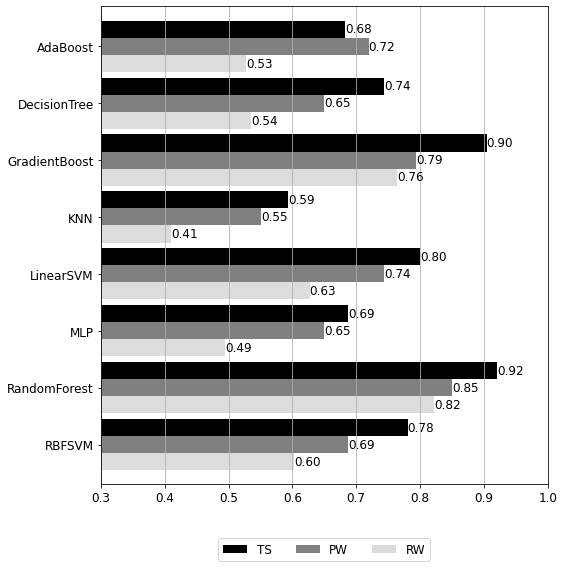

In [12]:
font = {'family' : 'normal',
        'size'   : 12}
pyplt.rc('font', **font)
pyplt.rcParams["figure.figsize"] = (8,8)

plt = plot_data.plot.barh(x='Model',y=DATASET_IDS,color=['black','gray','gainsboro','darkgray','lightgray'],width=0.9)
plt.legend(loc='upper center',ncol=5,bbox_to_anchor=(0.5,-0.1))
plt.set_xlim([0.3,1.0])
plt.invert_yaxis()
plt.set_ylabel('')
plt.grid(axis='x')
#plt.set_xticklabels(MODELS, rotation=0, ha='center')

for container in plt.containers:
  plt.bar_label(container,fmt='%.2f')
plt.get_figure().tight_layout()
plt.get_figure().savefig('brssi_model_results.pdf')